<a href="https://colab.research.google.com/github/isj0/DeepLearning/blob/main/Test_Run_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 0. Import required libraries

import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the NSL-KDD dataset from HuggingFace
ds = load_dataset("Mireu-Lab/NSL-KDD")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# 2. convert HuggingFace datasets to pandas data frames
train = ds['train']
test = ds['test']
# Convert to DataFrame
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# shape of training data
print("Training set shape:", train_df.shape)

# shape of testing data
print("Testing set shape:", test_df.shape)

Training set shape: (151165, 42)
Testing set shape: (34394, 42)


In [4]:
# 3. Check initial class distribution

print("Unique classes (train):", train_df['class'].unique())
print("Unique classes (test):", test_df['class'].unique())

Unique classes (train): ['normal' 'anomaly']
Unique classes (test): ['anomaly' 'normal']


In [5]:
# 4. Remove duplicate rows
# ================================================================
print("Duplicates before removal (train):", train_df.duplicated().sum())
print("Duplicates before removal (test):", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

print("Duplicates after removal (train):", train_df.duplicated().sum())
print("Duplicates after removal (test):", test_df.duplicated().sum())

Duplicates before removal (train): 25201
Duplicates before removal (test): 11853
Duplicates after removal (train): 0
Duplicates after removal (test): 0


In [6]:
# 5. Convert class column to binary (0 = normal, 1 = attack)
# ================================================================
def convert_class(label):
    return 0 if label == 'normal' else 1

train_df['class'] = train_df['class'].apply(convert_class)
test_df['class'] = test_df['class'].apply(convert_class)

print(train_df['class'].value_counts())
print(test_df['class'].value_counts())

class
0    67343
1    58621
Name: count, dtype: int64
class
1    12830
0     9711
Name: count, dtype: int64


In [7]:
# 6. One-Hot Encode categorical columns
# ================================================================
categorical_columns = ['protocol_type', 'service', 'flag']

train_encoded = pd.get_dummies(train_df, columns=categorical_columns)
test_encoded = pd.get_dummies(test_df, columns=categorical_columns)

# Align test to training columns
# (Test may not contain some categories present in training)
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)


In [8]:
# 7. Split into X (features) and y (labels)
# ================================================================
X_train = train_encoded.drop('class', axis=1)
y_train = train_encoded['class']

X_test = test_encoded.drop('class', axis=1)
y_test = test_encoded['class']

In [9]:
print("Train NA count:", X_train.isna().sum().sum())
print("Test NA count:", X_test.isna().sum().sum())

Train NA count: 0
Test NA count: 0


In [10]:
# 8. Scale features
# ================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 9. Apply PCA (retain 95% variance)
# ================================================================
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA components:", X_train_pca.shape[1])

PCA components: 89


In [12]:
# 10. Sanity checks and validation

print("Columns aligned:", X_train.columns.equals(X_test.columns))

total_var = pca.explained_variance_ratio_.sum()
print(f"PCA explained variance: {total_var:.4f}")
print(f"PCA n_components: {X_train_pca.shape[1]}")

attack_ratio_train = y_train.mean()
attack_ratio_test = y_test.mean()
print(f"Attack ratio (train): {attack_ratio_train:.4f}")
print(f"Attack ratio (test): {attack_ratio_test:.4f}")

Columns aligned: True
PCA explained variance: 0.9526
PCA n_components: 89
Attack ratio (train): 0.4654
Attack ratio (test): 0.5692


In [13]:
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    return acc, prec, rec, f1, cm

In [14]:
# ---------------------------------------------------
# Function to plot confusion matrix
# ---------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, model_name, normalize=False):
    """
    Plot a confusion matrix using seaborn heatmap.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - model_name: string, model name for title
    - normalize: bool, if True, show percentages instead of counts
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


In [15]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', gamma='scale', random_state=42),
}

In [16]:
for name, model in models.items():
    print("\n=======================================")
    print(f"Model: {name}")

    acc, prec, rec, f1, cm = evaluate(model, X_train_pca, X_test_pca, y_train, y_test)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


Model: Decision Tree
Accuracy:  0.7922
Precision: 0.9305
Recall:    0.6862
F1 Score:  0.7899
Confusion Matrix:
[[9053  658]
 [4026 8804]]

Model: Random Forest
Accuracy:  0.7968
Precision: 0.9695
Recall:    0.6639
F1 Score:  0.7881
Confusion Matrix:
[[9443  268]
 [4312 8518]]

Model: SVM (RBF)
Accuracy:  0.8021
Precision: 0.9265
Recall:    0.7086
F1 Score:  0.8030
Confusion Matrix:
[[8990  721]
 [3739 9091]]


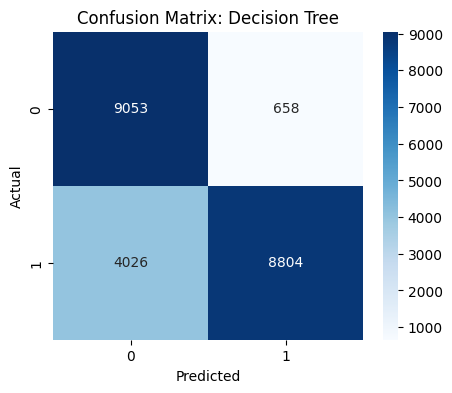

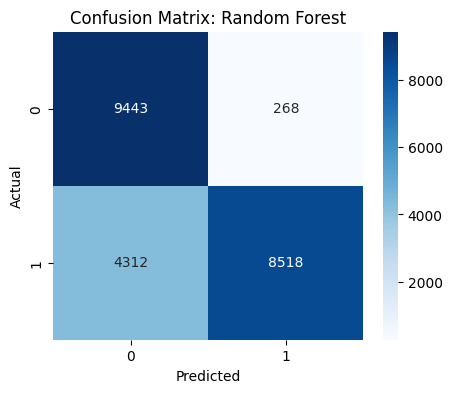

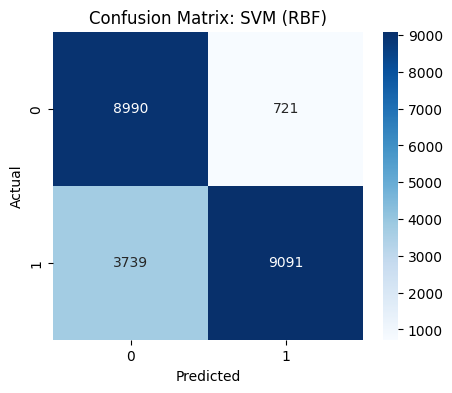

In [17]:
for name, model in models.items():
    y_pred = model.predict(X_test_pca)  # just predict, no training
    plot_confusion_matrix(y_test, y_pred, name)

In [18]:
# ================================================================
# Baseline Models with Class Weighting / Imbalance Handling
# ================================================================

# ------------------------------
# 1. Define models
# DecisionTree, RandomForest, and SVM support 'class_weight' directly
# MLP does not support class_weight or sample_weight in scikit-learn (solver='adam')
# ------------------------------
models_weighted = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', gamma='scale', class_weight='balanced', random_state=42),
}

# ------------------------------
# 2. Evaluation function
# ------------------------------
def evaluate_weighted(model, X_train, X_test, y_train, y_test, sample_weight=None, model_name=None):
    """
    Train the model on training data and evaluate on test data.

    Parameters:
    - model: classifier
    - X_train, y_train: training data
    - X_test, y_test: test data
    - sample_weight: optional weights (used for MLP workaround)
    - model_name: used to skip sample_weight for MLP

    Returns:
    - acc, prec, rec, f1: metrics
    - cm: confusion matrix
    """
    # DT, RF, SVM can use sample_weight
    model.fit(X_train, y_train, sample_weight=sample_weight)

    # Predict on test set
    preds = model.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    return acc, prec, rec, f1, cm

# ------------------------------
# 3. Train & evaluate each model
# ------------------------------
for name, model in models_weighted.items():
    print("\n=======================================")
    print(f"Model: {name}")

    sample_weight = None
    # Train and evaluate
    acc, prec, rec, f1, cm = evaluate_weighted(
        model, X_train_scaled, X_test_scaled, y_train, y_test,
        sample_weight=sample_weight, model_name=name
    )

    # Print metrics
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)



Model: Decision Tree
Accuracy:  0.8093
Precision: 0.9584
Recall:    0.6952
F1 Score:  0.8058
Confusion Matrix:
[[9324  387]
 [3911 8919]]

Model: Random Forest
Accuracy:  0.7757
Precision: 0.9682
Recall:    0.6266
F1 Score:  0.7608
Confusion Matrix:
[[9447  264]
 [4791 8039]]

Model: SVM (RBF)
Accuracy:  0.7890
Precision: 0.9245
Recall:    0.6852
F1 Score:  0.7871
Confusion Matrix:
[[8993  718]
 [4039 8791]]


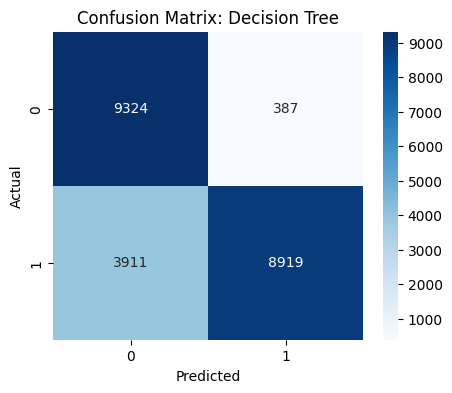

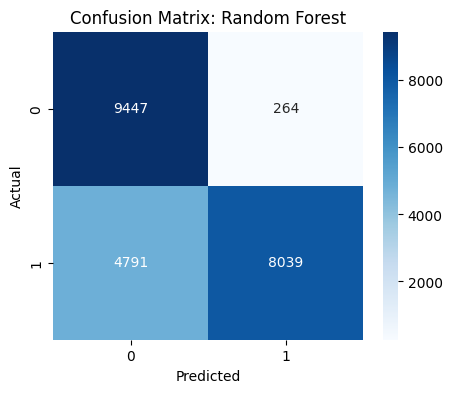

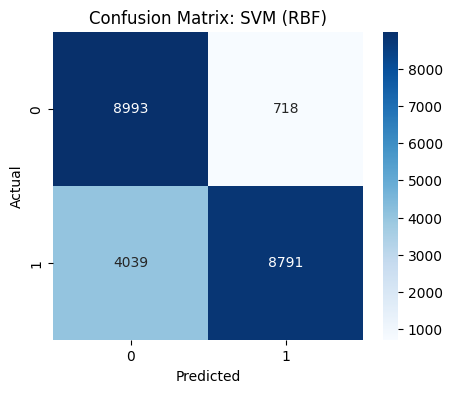

In [22]:
for name, model in models_weighted.items():
    y_pred = model.predict(X_test_scaled)  # just predict
    plot_confusion_matrix(y_test, y_pred, name)


In [19]:
# ================================================================
# Train Isolation Forest (unsupervised)
# ================================================================

# Step 1: Initialize model
# - n_estimators: number of trees
# - max_samples: number of samples used to build each tree
# - contamination: expected fraction of anomalies in data
# - random_state: for reproducibility
iso_forest = IsolationForest(
    n_estimators=100,      # 100 trees is a good beginner-friendly default
    max_samples='auto',    # automatically set to min(256, n_samples)
    contamination=0.1,     # assume ~10% attacks; adjust if needed
    random_state=42,
    verbose=0
)

# Step 2: Train model
# We use only X_train features (unsupervised — no labels needed)
iso_forest.fit(X_train_pca)

# Step 3: Predict on test set
# Returns -1 (anomaly) or 1 (normal)
y_pred_if = iso_forest.predict(X_test_pca)

# Step 4: Convert predictions to 0 (normal) / 1 (attack)
y_pred_if_binary = np.where(y_pred_if == -1, 1, 0)

# Step 5: Evaluate performance

acc = accuracy_score(y_test, y_pred_if_binary)
prec = precision_score(y_test, y_pred_if_binary)
rec = recall_score(y_test, y_pred_if_binary)
f1 = f1_score(y_test, y_pred_if_binary)
cm = confusion_matrix(y_test, y_pred_if_binary)

# Step 6: Print results
print("\n=======================================")
print("Isolation Forest (unsupervised) Results")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)



Isolation Forest (unsupervised) Results
Accuracy:  0.5583
Precision: 0.9597
Recall:    0.2337
F1 Score:  0.3759
Confusion Matrix:
[[9585  126]
 [9831 2999]]


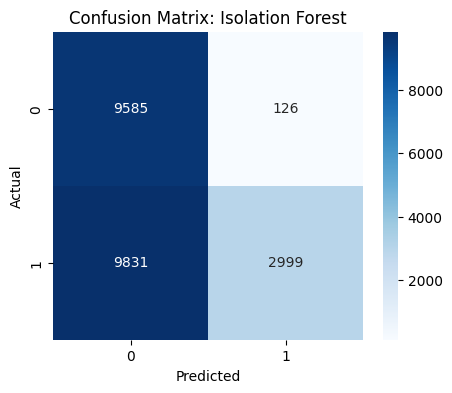

In [23]:
plot_confusion_matrix(y_test, y_pred_if_binary, "Isolation Forest")


In [20]:
# ---------------------------------------------
# Ensemble Models
# ---------------------------------------------

ensemble_models = {
    "Soft Voting": VotingClassifier(
        estimators=[
            ("dt", DecisionTreeClassifier(random_state=42)),
            ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
            ("svm", SVC(kernel='rbf', probability=True, random_state=42))
        ],
        voting='soft'
    ),

    "Bagging (Decision Tree)": BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=50,
        random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        random_state=42
    )
}


In [21]:
# ---------------------------------------------
# Train and evaluate ensemble models
# ---------------------------------------------
print("\n==============================")
print("  Ensemble Model Results")
print("==============================")

for name, model in ensemble_models.items():
    print("\n=======================================")
    print(f"Model: {name}")

    acc, prec, rec, f1, cm = evaluate(model, X_train_scaled, X_test_scaled, y_train, y_test)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)



  Ensemble Model Results

Model: Soft Voting
Accuracy:  0.7899
Precision: 0.9683
Recall:    0.6523
F1 Score:  0.7795
Confusion Matrix:
[[9437  274]
 [4461 8369]]

Model: Bagging (Decision Tree)
Accuracy:  0.8059
Precision: 0.9690
Recall:    0.6807
F1 Score:  0.7997
Confusion Matrix:
[[9432  279]
 [4097 8733]]

Model: AdaBoost
Accuracy:  0.7827
Precision: 0.9580
Recall:    0.6465
F1 Score:  0.7720
Confusion Matrix:
[[9347  364]
 [4535 8295]]

Model: Gradient Boosting
Accuracy:  0.7943
Precision: 0.9707
Recall:    0.6585
F1 Score:  0.7847
Confusion Matrix:
[[9456  255]
 [4382 8448]]


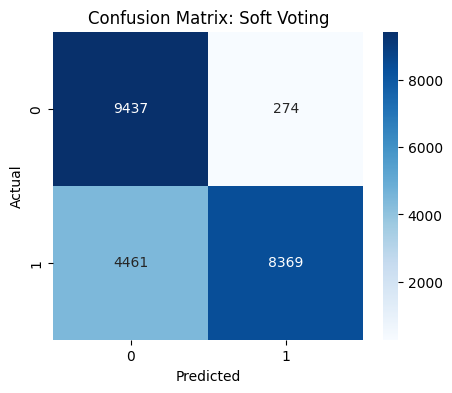

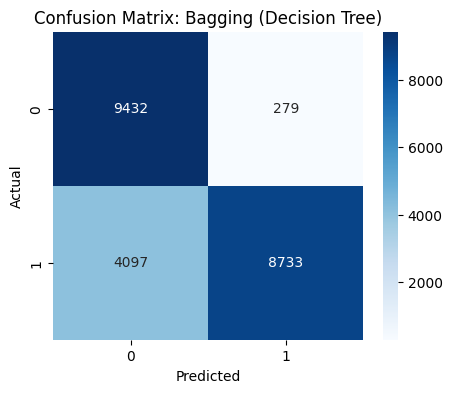

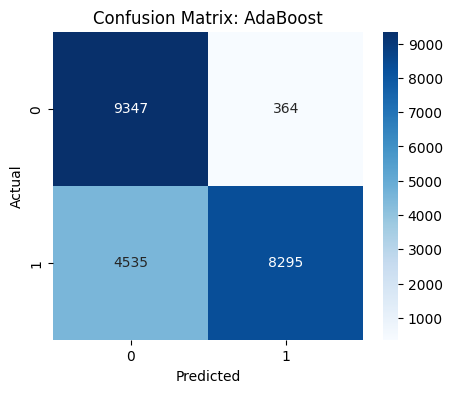

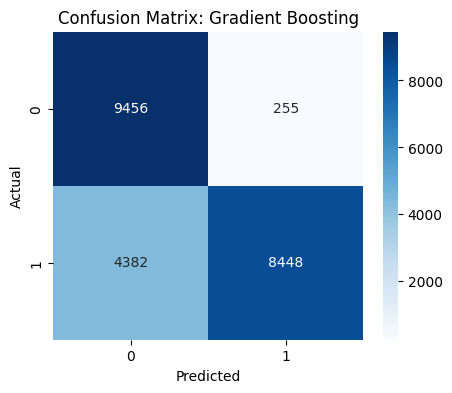

In [24]:
for name, model in ensemble_models.items():
    y_pred = model.predict(X_test_scaled)  # just predict
    plot_confusion_matrix(y_test, y_pred, name)
